<br />
<center><font size='6px' color='#mmvvbb'><b>Tweets Classification</b></font>
<br />

## Installation 

In [91]:
!pip install tweepy

In [92]:
!pip install spacy
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


## Import libraries

In [15]:
import pandas as pd
import spacy
import en_core_web_sm
import tweepy
import os
import numpy as np
import datetime
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import RegexpTokenizer, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from string import punctuation
import collections
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer ,TfidfTransformer  
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from sklearn.cluster import KMeans
%matplotlib inline

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## The twitter API authorization

In [9]:
consumer_key = "2efcnJkOeJIxOJwUXUgLwB3kt"
consumer_secret = "54NM4oJE1CKY6hizIUkS3qeKAmrtokXVOdGHMAy6l90UbGlqUb"
access_token = "1325789903142211593-4cpFSFq3HYHgwiDs3CqgJu7hucWynK"
access_token_secret = "z8lC2xyIbaQYqDgpSPaOXcMLZIzLi10iuoweMRYHqIpUl"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

#public_tweets = api.home_timeline()
#for tweet in public_tweets:
#    print(tweet.text)


In [13]:
filename = 'Datasets/twitter_data_analysis2'+(datetime.datetime.now().strftime("%Y-%m-%d-%H"))+'.csv'
with open (filename, 'a+', newline='',encoding="utf-8") as csvFile:
    csvWriter = csv.writer(csvFile)
    csvWriter.writerow(['date', 'TweetId','Tweet','created_at','location'])
    #using tweepy Cursor
    #for tweet in tweepy.Cursor(api.search, q='universalhealthcare', lang = 'en', count=1000).items():
    for tweet in tweepy.Cursor(api.user_timeline , id="twitter").items(10000):
    #writing a csv file
        tweets_encoded = tweet.text.encode('utf-8')
        tweets_decoded = tweets_encoded.decode('utf-8')
        #csvWriter.writerow([tweet.id_str, tweet.created_at, tweet.text, tweet.favorite_count, tweet.retweet_count, tweet.entities, tweet.lang])
        csvWriter.writerow([datetime.datetime.now().strftime("%Y-%m-%d  %H:%M"), tweet.id, tweets_decoded, tweet.created_at, tweet._json["user"]["location"]])

## Load dataset from csv file

In [16]:
def load_data():
    data = pd.read_csv('Datasets/twitter_data_analysis2020-11-19-19.csv')
    return data

In [17]:
tweet_df = load_data()
tweet_df.head()

,date,TweetId,Tweet,created_at,location
0,date,TweetId,Tweet,created_at,location
1,2020-11-19 19:31,1329474353705136138,RT @AgapeLoveAllDay: Why am I on fire this mor...,2020-11-19 17:19:21,A dock on a lake in Michigan.
2,2020-11-19 19:31,1329448623734738944,@nyctaxicabtales\nCouple From #Wisconsin Said:...,2020-11-19 15:37:06,New York City
3,2020-11-19 19:31,1329443503374553089,@KamalaHarris @JoeBiden \nI know #UniversalHea...,2020-11-19 15:16:45,Wakanda
4,2020-11-19 19:31,1329434910315175936,Why am I on fire this morning? I am tired of w...,2020-11-19 14:42:36,Wakanda


## Structure

#### Display the size of the dataset 
(number of rows and number of columns)

In [26]:
# Affichage de la taille du dataset (n_lignes and n_colonnes)
print('Dataset size:',tweet_df.shape)
print('Columns are:',tweet_df.columns)

Dataset size: (1252, 5)
Columns are: Index(['date', 'TweetId', 'Tweet', 'created_at', 'location'], dtype='object')


#### Display the dataset informations

In [27]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1252 entries, 0 to 1251
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        1252 non-null   object
 1   TweetId     1252 non-null   object
 2   Tweet       1252 non-null   object
 3   created_at  1252 non-null   object
 4   location    926 non-null    object
dtypes: object(5)
memory usage: 49.0+ KB


#### Create dataframe 

In [25]:
df  = pd.DataFrame(tweet_df[['TweetId', 'Tweet']])

## Pre-processing text data

Most of the text data are cleaned by following below steps.
1. Remove punctuations
2. Tokenization - Converting a sentence into list of words
3. Remove stopwords
4. Lammetization/stemming - Tranforming any form of a word to its root word

#### 1. Remove punctuations

In [28]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [29]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

df['Tweet_punct'] = df['Tweet'].apply(lambda x: remove_punct(x))
df.head(10)

,TweetId,Tweet,Tweet_punct
0,TweetId,Tweet,Tweet
1,1329474353705136138,RT @AgapeLoveAllDay: Why am I on fire this mor...,RT AgapeLoveAllDay Why am I on fire this morni...
2,1329448623734738944,@nyctaxicabtales\nCouple From #Wisconsin Said:...,nyctaxicabtales\nCouple From Wisconsin Said Th...
3,1329443503374553089,@KamalaHarris @JoeBiden \nI know #UniversalHea...,KamalaHarris JoeBiden \nI know UniversalHealth...
4,1329434910315175936,Why am I on fire this morning? I am tired of w...,Why am I on fire this morning I am tired of wa...
5,1329433754830565384,RT @AgapeLoveAllDay: I don't do what I do for ...,RT AgapeLoveAllDay I dont do what I do for pra...
6,1329433466375692298,I don't do what I do for praise or accolades. ...,I dont do what I do for praise or accolades I ...
7,1329429029661892608,"RT @AgapeLoveAllDay: The point is, we need to ...",RT AgapeLoveAllDay The point is we need to be ...
8,1329424242576928768,@axlsgirl13 This is what I see regularly as an...,axlsgirl This is what I see regularly as an on...
9,1329422168430694401,RT @AgapeLoveAllDay: I want to speak to @JoeBi...,RT AgapeLoveAllDay I want to speak to JoeBiden...


#### 2. Tokenization

In [30]:
def tokenization(text):
    text = re.split(' ', text)
    return text

df['Tweet_tokenized'] = df['Tweet_punct'].apply(lambda x: tokenization(x.lower()))
df.head()

,TweetId,Tweet,Tweet_punct,Tweet_tokenized
0,TweetId,Tweet,Tweet,[tweet]
1,1329474353705136138,RT @AgapeLoveAllDay: Why am I on fire this mor...,RT AgapeLoveAllDay Why am I on fire this morni...,"[rt, agapeloveallday, why, am, i, on, fire, th..."
2,1329448623734738944,@nyctaxicabtales\nCouple From #Wisconsin Said:...,nyctaxicabtales\nCouple From Wisconsin Said Th...,"[nyctaxicabtales\ncouple, from, wisconsin, sai..."
3,1329443503374553089,@KamalaHarris @JoeBiden \nI know #UniversalHea...,KamalaHarris JoeBiden \nI know UniversalHealth...,"[kamalaharris, joebiden, \ni, know, universalh..."
4,1329434910315175936,Why am I on fire this morning? I am tired of w...,Why am I on fire this morning I am tired of wa...,"[why, am, i, on, fire, this, morning, i, am, t..."


#### 3. Remove stopwords

In [31]:
stopword = nltk.corpus.stopwords.words('english')

In [32]:
stopword.extend(['old', 'new', 'age', 'lot', 'bag', 'top', 'cat', 'bat', 'sap', 'jda', 'tea', 'dog', 'lie', 'law', 'lab',\
             'mob', 'map', 'car', 'fat', 'sea', 'saw', 'raw', 'rob', 'win', 'can', 'get', 'fan', 'fun', 'big',\
             'use', 'pea', 'pit','pot', 'pat', 'ear', 'eye', 'kit', 'pot', 'pen', 'bud', 'bet', 'god', 'tax', 'won', 'run',\
              'lid', 'log', 'pr', 'pd', 'cop', 'nyc', 'ny', 'la', 'toy', 'war', 'law', 'lax', 'jfk', 'fed', 'cry', 'ceo',\
              'pay', 'pet', 'fan', 'fun', 'usd', 'rio',':)', ';)', '(:', '(;', '}', '{','}','here', 'there', 'where', 'when', 'would', 'should', 'could','thats', 'youre', 'thanks', 'hasn',\
             'thank', 'https', 'since', 'wanna', 'gonna', 'aint', 'http', 'unto', 'onto', 'into', 'havent',\
             'dont', 'done', 'cant', 'werent', 'https', 'u', 'isnt', 'go', 'theyre', 'each', 'every', 'shes', 'youve', 'youll',\
            'weve', 'theyve','googleele' , 'goog', 'lyin', 'lie', 'googles', 'goog', 'aapl','apple',\
             'msft','microsoft', 'google', 'goog', 'googl','goog'])

In [33]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
df['Tweet_nonstop'] = df['Tweet_tokenized'].apply(lambda x: remove_stopwords(x))
df.head(10)

,TweetId,Tweet,Tweet_punct,Tweet_tokenized,Tweet_nonstop
0,TweetId,Tweet,Tweet,[tweet],[tweet]
1,1329474353705136138,RT @AgapeLoveAllDay: Why am I on fire this mor...,RT AgapeLoveAllDay Why am I on fire this morni...,"[rt, agapeloveallday, why, am, i, on, fire, th...","[rt, agapeloveallday, fire, morning, tired, wa..."
2,1329448623734738944,@nyctaxicabtales\nCouple From #Wisconsin Said:...,nyctaxicabtales\nCouple From Wisconsin Said Th...,"[nyctaxicabtales\ncouple, from, wisconsin, sai...","[nyctaxicabtales\ncouple, wisconsin, said, rep..."
3,1329443503374553089,@KamalaHarris @JoeBiden \nI know #UniversalHea...,KamalaHarris JoeBiden \nI know UniversalHealth...,"[kamalaharris, joebiden, \ni, know, universalh...","[kamalaharris, joebiden, \ni, know, universalh..."
4,1329434910315175936,Why am I on fire this morning? I am tired of w...,Why am I on fire this morning I am tired of wa...,"[why, am, i, on, fire, this, morning, i, am, t...","[fire, morning, tired, watching, people, suffe..."
5,1329433754830565384,RT @AgapeLoveAllDay: I don't do what I do for ...,RT AgapeLoveAllDay I dont do what I do for pra...,"[rt, agapeloveallday, i, dont, do, what, i, do...","[rt, agapeloveallday, praise, accolades, tell,..."
6,1329433466375692298,I don't do what I do for praise or accolades. ...,I dont do what I do for praise or accolades I ...,"[i, dont, do, what, i, do, for, praise, or, ac...","[praise, accolades, tell, stories, reasons, sa..."
7,1329429029661892608,"RT @AgapeLoveAllDay: The point is, we need to ...",RT AgapeLoveAllDay The point is we need to be ...,"[rt, agapeloveallday, the, point, is, we, need...","[rt, agapeloveallday, point, need, less, selfi..."
8,1329424242576928768,@axlsgirl13 This is what I see regularly as an...,axlsgirl This is what I see regularly as an on...,"[axlsgirl, this, is, what, i, see, regularly, ...","[axlsgirl, see, regularly, oncology, nurse, si..."
9,1329422168430694401,RT @AgapeLoveAllDay: I want to speak to @JoeBi...,RT AgapeLoveAllDay I want to speak to JoeBiden...,"[rt, agapeloveallday, i, want, to, speak, to, ...","[rt, agapeloveallday, want, speak, joebiden, k..."


#### 4. Stemming and Lammitization
Ex - developed, development

In [34]:
ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

df['Tweet_stemmed'] = df['Tweet_nonstop'].apply(lambda x: stemming(x))
df.head()

,TweetId,Tweet,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed
0,TweetId,Tweet,Tweet,[tweet],[tweet],[tweet]
1,1329474353705136138,RT @AgapeLoveAllDay: Why am I on fire this mor...,RT AgapeLoveAllDay Why am I on fire this morni...,"[rt, agapeloveallday, why, am, i, on, fire, th...","[rt, agapeloveallday, fire, morning, tired, wa...","[rt, agapeloveallday, fire, morn, tire, watch,..."
2,1329448623734738944,@nyctaxicabtales\nCouple From #Wisconsin Said:...,nyctaxicabtales\nCouple From Wisconsin Said Th...,"[nyctaxicabtales\ncouple, from, wisconsin, sai...","[nyctaxicabtales\ncouple, wisconsin, said, rep...","[nyctaxicabtales\ncoupl, wisconsin, said, repu..."
3,1329443503374553089,@KamalaHarris @JoeBiden \nI know #UniversalHea...,KamalaHarris JoeBiden \nI know UniversalHealth...,"[kamalaharris, joebiden, \ni, know, universalh...","[kamalaharris, joebiden, \ni, know, universalh...","[kamalaharri, joebiden, \ni, know, universalhe..."
4,1329434910315175936,Why am I on fire this morning? I am tired of w...,Why am I on fire this morning I am tired of wa...,"[why, am, i, on, fire, this, morning, i, am, t...","[fire, morning, tired, watching, people, suffe...","[fire, morn, tire, watch, peopl, suffer, even,..."


In [35]:
wn = nltk.WordNetLemmatizer()

def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

df['Tweet_lemmatized'] = df['Tweet_nonstop'].apply(lambda x: lemmatizer(x))
df.head()

,TweetId,Tweet,Tweet_punct,Tweet_tokenized,Tweet_nonstop,Tweet_stemmed,Tweet_lemmatized
0,TweetId,Tweet,Tweet,[tweet],[tweet],[tweet],[tweet]
1,1329474353705136138,RT @AgapeLoveAllDay: Why am I on fire this mor...,RT AgapeLoveAllDay Why am I on fire this morni...,"[rt, agapeloveallday, why, am, i, on, fire, th...","[rt, agapeloveallday, fire, morning, tired, wa...","[rt, agapeloveallday, fire, morn, tire, watch,...","[rt, agapeloveallday, fire, morning, tired, wa..."
2,1329448623734738944,@nyctaxicabtales\nCouple From #Wisconsin Said:...,nyctaxicabtales\nCouple From Wisconsin Said Th...,"[nyctaxicabtales\ncouple, from, wisconsin, sai...","[nyctaxicabtales\ncouple, wisconsin, said, rep...","[nyctaxicabtales\ncoupl, wisconsin, said, repu...","[nyctaxicabtales\ncouple, wisconsin, said, rep..."
3,1329443503374553089,@KamalaHarris @JoeBiden \nI know #UniversalHea...,KamalaHarris JoeBiden \nI know UniversalHealth...,"[kamalaharris, joebiden, \ni, know, universalh...","[kamalaharris, joebiden, \ni, know, universalh...","[kamalaharri, joebiden, \ni, know, universalhe...","[kamalaharris, joebiden, \ni, know, universalh..."
4,1329434910315175936,Why am I on fire this morning? I am tired of w...,Why am I on fire this morning I am tired of wa...,"[why, am, i, on, fire, this, morning, i, am, t...","[fire, morning, tired, watching, people, suffe...","[fire, morn, tire, watch, peopl, suffer, even,...","[fire, morning, tired, watching, people, suffe..."


In [36]:
df.Tweet_lemmatized

0                                                 [tweet]
1       [rt, agapeloveallday, fire, morning, tired, wa...
2       [nyctaxicabtales\ncouple, wisconsin, said, rep...
3       [kamalaharris, joebiden, \ni, know, universalh...
4       [fire, morning, tired, watching, people, suffe...
                              ...                        
1247    [fix, even, pandemic, , american, lost, health...
1248    [want, universal, healthcare, citizen, united,...
1249    [🚨🚨open, enrollment, aca, begun, end, december...
1250    [danpriceseattle, universalhealthcare, \n\nyes...
1251    [thedemocrats, joebiden, pas, universalhealthc...
Name: Tweet_lemmatized, Length: 1252, dtype: object

In [37]:
df.Tweet_lemmatized.to_csv('Datasets/new_tweets_clean.csv',index = False)

In [38]:
# remove the hashtags, mentions and unwanted characters.
new_tweet_df= pd.read_csv('Datasets/new_tweets_clean.csv')
print('Dataset size:',new_tweet_df.shape)
print('Columns are:',new_tweet_df.columns)
new_tweet_df.info()
new_tweet_df.head()

Dataset size: (1252, 1)
Columns are: Index(['Tweet_lemmatized'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1252 entries, 0 to 1251
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Tweet_lemmatized  1252 non-null   object
dtypes: object(1)
memory usage: 9.9+ KB


,Tweet_lemmatized
0,['tweet']
1,"['rt', 'agapeloveallday', 'fire', 'morning', '..."
2,"['nyctaxicabtales\ncouple', 'wisconsin', 'said..."
3,"['kamalaharris', 'joebiden', '\ni', 'know', 'u..."
4,"['fire', 'morning', 'tired', 'watching', 'peop..."


In [39]:
cv = CountVectorizer()
X=cv.fit_transform(new_tweet_df.Tweet_lemmatized)
print(X)

  (0, 1963)	1
  (1, 1717)	1
  (1, 47)	1
  (1, 562)	1
  (1, 1293)	1
  (1, 1939)	1
  (1, 2040)	1
  (1, 1506)	1
  (1, 1879)	1
  (1, 514)	1
  (1, 463)	1
  (1, 1517)	1
  (1, 1482)	1
  (1, 1153)	1
  (2, 1447)	1
  (2, 1332)	1
  (2, 2064)	1
  (2, 1722)	1
  (2, 1683)	1
  (2, 2018)	1
  (2, 1108)	1
  (2, 1122)	1
  (2, 153)	1
  (2, 986)	1
  (3, 2040)	1
  :	:
  (1249, 1914)	1
  (1249, 240)	1
  (1249, 1789)	1
  (1249, 11)	2
  (1249, 1941)	1
  (1249, 488)	1
  (1249, 1466)	1
  (1249, 494)	1
  (1249, 156)	1
  (1249, 378)	1
  (1250, 1986)	1
  (1250, 1526)	1
  (1250, 365)	1
  (1250, 1448)	1
  (1250, 1452)	1
  (1250, 1804)	1
  (1251, 1108)	1
  (1251, 1986)	1
  (1251, 1493)	1
  (1251, 1620)	1
  (1251, 1538)	1
  (1251, 1918)	1
  (1251, 1545)	1
  (1251, 1417)	1
  (1251, 1050)	1


In [40]:
wcss=[]
for i in range(3,30):
    Kmeans=KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0,verbose=True)
    Kmeans.fit(X)
    wcss.append(Kmeans.inertia_)

Initialization complete
Iteration  0, inertia 14580.000
Iteration  1, inertia 11803.990
Converged at iteration 1: center shift 0.000000e+00 within tolerance 5.194706e-07
Initialization complete
Iteration  0, inertia 20388.000
Iteration  1, inertia 10631.512
Iteration  2, inertia 10288.092
Converged at iteration 2: center shift 0.000000e+00 within tolerance 5.194706e-07
Initialization complete
Iteration  0, inertia 22236.000
Iteration  1, inertia 11796.729
Iteration  2, inertia 11794.858
Converged at iteration 2: center shift 0.000000e+00 within tolerance 5.194706e-07
Initialization complete
Iteration  0, inertia 16460.000
Iteration  1, inertia 10288.092
Converged at iteration 1: center shift 0.000000e+00 within tolerance 5.194706e-07
Initialization complete
Iteration  0, inertia 20844.000
Iteration  1, inertia 11814.485
Iteration  2, inertia 11808.204
Iteration  3, inertia 11803.531
Converged at iteration 3: center shift 0.000000e+00 within tolerance 5.194706e-07
Initialization complet

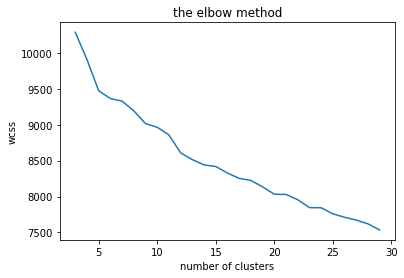

In [41]:
import matplotlib.pyplot as plt
plt.plot(range(3,30),wcss)
plt.title('the elbow method')
plt.xlabel('number of clusters')
plt.ylabel('wcss')
plt.show()

In [42]:
true_k=30
Kmeans=KMeans(n_clusters=true_k,init='k-means++',n_init=1)
Kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=30, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [43]:
print("Top terms per cluster:")
order_centroids = Kmeans.cluster_centers_.argsort()[:, ::-1]
terms = cv.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i)
    print("-----------------------")
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print()
print("\n")

Top terms per cluster:
Cluster 0:
-----------------------
 sticker
 vinyl
 health
 care
 socialism
 socialist
 nresistance
 anticapitalism
 antiracist
 pixelswork

Cluster 1:
-----------------------
 shared
 joebiden
 kamalaharris
 stage
 candidate
 better
 httpstcosnokgtifg
 many
 aca
 hit

Cluster 2:
-----------------------
 sheer
 worked
 dems
 healthcare
 plan
 american
 lunacy
 harveyjkaye
 rt
 coveragemedicareforall

Cluster 3:
-----------------------
 healthcare
 exist
 administrative
 need
 middleman
 cost
 reason
 rd
 forprofit
 nany

Cluster 4:
-----------------------
 wake
 wow
 httpstcopbpngiyon
 universalhealthcare
 bidenharris
 american
 powerful
 highlight
 hinder
 hillary

Cluster 5:
-----------------------
 dentistry
 health
 call
 socialist
 aspect
 ltc
 healthcare
 mental
 chiropractic
 including

Cluster 6:
-----------------------
 smartdissent
 httpstcoazppibumz
 health
 insurance
 lost
 obamacare
 rt
 american
 icymi
 trump

Cluster 7:
-----------------------
 fla

In [44]:
i=0
j=0
while i<30:
    while True: 
        Y=cv.transform([new_tweet_df.Tweet_lemmatized[j]])
        prediction=Kmeans.predict(Y)
        if i == prediction:
            print("tweet of cluster "+str(prediction)+df.Tweet[i])
            j=0
            break
        j+=1
    i+=1

tweet of cluster [0]Tweet
tweet of cluster [1]RT @AgapeLoveAllDay: Why am I on fire this morning? I am tired of watching people suffer. Even if we can't ease physical pain, we can at le…
tweet of cluster [2]@nyctaxicabtales
Couple From #Wisconsin Said: They Are #Republicans - Voted For @JoeBiden @KamalaHarris , Because… https://t.co/Xnnub2s88r
tweet of cluster [3]@KamalaHarris @JoeBiden 
I know #UniversalHealthcare is not something you think America wants. I am an RN watching,… https://t.co/Xqk55h2TQm
tweet of cluster [4]Why am I on fire this morning? I am tired of watching people suffer. Even if we can't ease physical pain, we can at… https://t.co/UDXtmrSkf5
tweet of cluster [5]RT @AgapeLoveAllDay: I don't do what I do for praise or accolades. I don't tell my stories for those reasons. I do and say what I do becaus…
tweet of cluster [6]I don't do what I do for praise or accolades. I don't tell my stories for those reasons. I do and say what I do bec… https://t.co/lLxrQO51Dk
tweet of c

In [45]:
economy_related_words = '''agriculture infrastructure capitalism trading service sector technology  economical supply industrialism efficiency frugality retrenchment downsizing credit debit value economize save economically economies sluggish rise rising spending conserve trend low-management decline industry impact poor profession surplus fall declining accelerating interest sectors balance stability productivity increase rates pushing expanding stabilize  rate industrial borrowing struggling deficit predicted increasing data economizer analysts investment market-based economy debt free enterprise medium  exchange metric savepoint scarcity capital bank company stockholder fund business asset treasury tourism incomes contraction employment jobs upturn deflation  macroeconomics  bankruptcies exporters hyperinflation dollar entrepreneurship upswing marketplace commerce devaluation quicksave deindustrialization stockmarket reflation downspin dollarization withholder bankroll venture capital mutual fund plan economy mortgage lender unemployment rate credit crunch central bank financial institution bank rate custom duties mass-production black-market developing-countries developing economic-growth gdp trade barter distribution downturn economist'''

In [46]:
social_related_words = '''sociable, gregarious societal friendly society socialization political sociality interpersonal ethnic socially party welfare public community socialist societies development network humans socialism collective personal corporation social constructivism relations volition citizenship brute attitude rights socio socioeconomic ethics civic communal marital sociale socialized communities policy unions institutions values governmental organizations jamboree festivity fairness support care sides activism unsocial psychosocial socializing psychological distributional demographic participation reunion partygoer partyism festive power network gala housewarming celebration counterparty social-war particularist interactional ideational asocial'''

In [47]:
culture_related_words = ''' ethnicity heritage modernity spirituality marxismmaterial culture ethos nationality humanism romanticism civilisation traditionalism genetics kinship heredity marriage indigenous archeology acculturate ontogenesis viniculture modern clothes rooted cicero societies history roots influence geography historical folk origins phenomenon teleology ancient aspects perspective liberalism nowadays community style unique prevalent describes today  origin   modernity beliefs  genre barbarian ethnic  colonization cultural universal organization western-civilization structuralism  culture  heathen pagan transculturation culture peasant classicist nativism anarchy ungrown philosophic cult consciousness islamist bro-culture evolve cultic diaspora aftergrowth native cultural-relativism mongolian cosmopolitan epistemology lifestyles diversity chauvinism westernization materialism vernacular homogeneity otherness holism tusculanae disputationes primitivism superficiality hedonism discourse puritanism modernism intellectualism  exclusiveness elitism  colonialism pentecostalism paganism nationwide expansion rural auxesis kimono culturize alethophobia nettlebed japanification  dongyi clannishness insularity hybridity westernisation foreignness worldview exclusionism enculturation ethnocentrism confucianist vulgarization shintoism  westernism denominationalism deracination eurocentrism cosmologies  emotiveness bohemianism territorialism philosophical-doctrine ethnic minority social-darwinism  theory cultural evolution belief systemfolk music traditional art house karl-marx theorymedia film-theory art history museum studies cultural artifact'''

In [48]:
health_related_words = '''disease obesity world health organization medicine nutrition well-being exercise welfare wellness health care public health nursing stress safety hygiene research social healthy condition aids epidemiology healthiness wellbeing care illness medical dieteducation infectious disease environmental healthcare physical fitness hospitals health care provider doctors healthy community design insurance sanitation human body patient mental health medicare agriculture health science fitnesshealth policy  weight loss physical therapy psychology pharmacy metabolic organism human lifestyle status unhealthy upbeat vaccination sleep condom alcohol smoking water family eudaimonia eudaemonia air house prevention genetics public families poor needs treatment communicable disease study protection malaria development food priority management healthful mental provide department administration programs help assistance funding environment improving emergency need program affected schools private mental illness treat diseases preparedness perinatal fertility sickness veterinary sanitary pharmacists behavioral midwives gerontology infertility hospitalization midwifery cholesterol childcare pediatrician pediatrics medicaid asthma pensions sicknesses push-up physical education body-mass-index eat well gymnastic apparatus tune up good morning bathing low blood-pressure heart attack health club ride-bike you feel good eczema urticaria dermatitis sunburn overwork manufacturing medical sociology need exercise run'''

In [49]:
nlp = en_core_web_sm.load() 
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop = set(nltk.corpus.stopwords.words('english'))
punctuation = list(string.punctuation) #already taken care of with the cleaning function.
stop.update(punctuation)
w_tokenizer = WhitespaceTokenizer()
def furnished(text):
    final_text = []
    for i in w_tokenizer.tokenize(text):
        if i.lower() not in stop:
            word1 = lemmatizer.lemmatize(i) 
            final_text.append(word1.lower())
    return " ".join(final_text)
df.Tweet = df.Tweet.apply(furnished)

In [50]:
economy = furnished(economy_related_words)
social = furnished(social_related_words)
culture = furnished(culture_related_words)
health = furnished(health_related_words)

In [51]:
string1 = economy
words = string1.split()
economy = " ".join(sorted(set(words), key=words.index))
economy
string1 = social
words = string1.split()
social = " ".join(sorted(set(words), key=words.index))
social
string1 = health
words = string1.split()
health = " ".join(sorted(set(words), key=words.index))
health
string1 = culture
words = string1.split()
culture = " ".join(sorted(set(words), key=words.index))
culture

'ethnicity heritage modernity spirituality marxismmaterial culture ethos nationality humanism romanticism civilisation traditionalism genetics kinship heredity marriage indigenous archeology acculturate ontogenesis viniculture modern clothes rooted cicero society history root influence geography historical folk origin phenomenon teleology ancient aspect perspective liberalism nowadays community style unique prevalent describes today belief genre barbarian ethnic colonization cultural universal organization western-civilization structuralism heathen pagan transculturation peasant classicist nativism anarchy ungrown philosophic cult consciousness islamist bro-culture evolve cultic diaspora aftergrowth native cultural-relativism mongolian cosmopolitan epistemology lifestyle diversity chauvinism westernization materialism vernacular homogeneity otherness holism tusculanae disputationes primitivism superficiality hedonism discourse puritanism modernism intellectualism exclusiveness elitism 

In [52]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return len(intersection)/len(union)
def get_scores(group,tweets):
    scores = []
    for tweet in tweets:
        s = jaccard_similarity(group, tweet)
        scores.append(s)
    return scores
e_scores = get_scores(economy, df.Tweet.to_list())
s_scores = get_scores(social, df.Tweet.to_list())
c_scores = get_scores(culture, df.Tweet.to_list())
h_scores = get_scores(health, df.Tweet.to_list())

In [53]:
# create a jaccard scored df.
data  = {'names':df.TweetId.to_list(),       'economic_score':e_scores,
         'social_score': s_scores, 'culture_score':c_scores, 'health_scores':h_scores}
scores_df = pd.DataFrame(data)
#assign classes based on highest score
def get_classes(l1, l2, l3, l4):
    econ = []
    socio = []
    cul = []
    heal = []
    for i, j, k, l in zip(l1, l2, l3, l4):
        m = max(i, j, k, l)
        if m == i:
            econ.append(1)
        else:
            econ.append(0)
        if m == j:
            socio.append(1)
        else:
            socio.append(0)        
        if m == k:
            cul.append(1)
        else:
            cul.append(0)  
        if m == l:
            heal.append(1)
        else:
            heal.append(0)   
            
    return econ, socio, cul, heal
l1 = scores_df.economic_score.to_list()
l2 = scores_df.social_score.to_list()
l3 = scores_df.culture_score.to_list()
l4 = scores_df.health_scores.to_list()
econ, socio, cul, heal = get_classes(l1, l2, l3, l4)
data = {'name': scores_df.names.to_list(), 'economic':econ, 'social':socio, 'culture':cul, 'health': heal}
class_df = pd.DataFrame(data)
#grouping the tweets by username
new_groups_df = class_df.groupby(['name']).sum()
#add a new totals column
new_groups_df['total'] = new_groups_df['health'] + new_groups_df['culture'] + new_groups_df['social'] +  new_groups_df['economic']
#add a new totals row
new_groups_df.loc["Total"] = new_groups_df.sum()  

In [54]:
scores_df

,names,economic_score,social_score,culture_score,health_scores
0,TweetId,0.107143,0.111111,0.107143,0.115385
1,1329474353705136138,0.600000,0.666667,0.600000,0.636364
2,1329448623734738944,0.638889,0.611111,0.638889,0.628571
3,1329443503374553089,0.648649,0.621622,0.648649,0.594595
4,1329434910315175936,0.638889,0.657143,0.638889,0.676471
...,...,...,...,...,...
1247,1326263386594832384,0.657143,0.628571,0.657143,0.647059
1248,1326247905599033344,0.655172,0.678571,0.655172,0.703704
1249,1326243421259001856,0.588235,0.606061,0.588235,0.625000
1250,1326236169110220801,0.593750,0.666667,0.593750,0.633333


In [55]:
new_groups_df

,economic,social,culture,health,total
name,,,,,
1326228966504456197,0,2,0,0,2
1326236169110220801,0,2,0,0,2
1326243421259001856,0,0,0,2,2
1326247905599033344,0,0,0,2,2
1326263386594832384,2,0,2,0,4
...,...,...,...,...,...
1329443503374553089,2,0,2,0,4
1329448623734738944,2,0,2,0,4
1329474353705136138,0,2,0,0,2


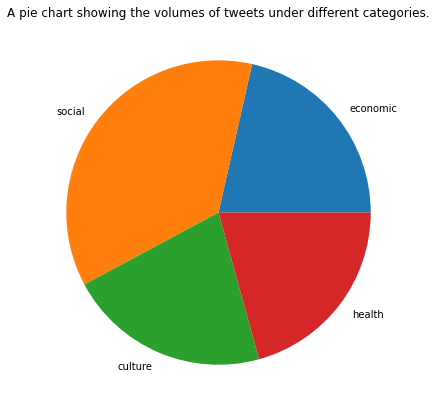

In [56]:
fig = plt.figure(figsize =(10, 7)) 
a = new_groups_df.drop(['total'], axis = 1)
plt.pie(a.loc['Total'], labels = a.columns)
plt.title('A pie chart showing the volumes of tweets under different categories.')
plt.show()

In [64]:
pd.show_versions(as_json=False)

C:\ProgramData\Anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(



INSTALLED VERSIONS
------------------
commit           : None
python           : 3.8.3.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
machine          : AMD64
processor        : Intel64 Family 6 Model 142 Stepping 12, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : fr_FR.cp1252

pandas           : 1.0.5
numpy            : 1.18.5
pytz             : 2020.1
dateutil         : 2.8.1
pip              : 20.1.1
setuptools       : 49.2.0.post20200714
Cython           : 0.29.21
pytest           : 5.4.3
hypothesis       : None
sphinx           : 3.1.2
blosc            : None
feather          : None
xlsxwriter       : 1.2.9
lxml.etree       : 4.5.2
html5lib         : 1.1
pymysql          : None
psycopg2         : None
jinja2           : 2.11.2
IPython          : 7.16.1
pandas_datareader: None
bs4              : 4.9.1
bottleneck       : 1.3.2
fastparquet      : None
gcsfs            : None
lxml.etree       :